<a href="https://colab.research.google.com/github/hmyrcmn/KUL/blob/main/cat_dog_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Kaggle API anahtarını yükle
uploaded = files.upload()

# Yüklenen kaggle.json dosyasını Colab dizinine taşı
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d erkamk/cat-and-dog-images-dataset
import zipfile
import os

# Zip dosyasını çıkart
with zipfile.ZipFile('/content/cat-and-dog-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# İçerideki dosyaları göster
os.listdir('/content/')


Saving kaggle.json to kaggle.json
 90% 115M/128M [00:01<00:00, 70.2MB/s]
100% 128M/128M [00:02<00:00, 67.0MB/s]


['.config',
 'X_gray.pickle',
 'y.npy',
 'cat-and-dog-images-dataset.zip',
 'x_gray.npy',
 'Dog and Cat .png',
 'y.pickle',
 'sample_data']

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split



image_dir = Path("/content/Dog and Cat .png")


filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)



image_df

,Filepath,Label
0,/content/Dog and Cat .png/Cat/t26.png,Cat
1,/content/Dog and Cat .png/Cat/257.png,Cat
2,/content/Dog and Cat .png/Cat/138.png,Cat
3,/content/Dog and Cat .png/Cat/359.png,Cat
4,/content/Dog and Cat .png/Cat/214.png,Cat
...,...,...
994,/content/Dog and Cat .png/Dog/d39.png,Dog
995,/content/Dog and Cat .png/Dog/d61.png,Dog
996,/content/Dog and Cat .png/Dog/d46.png,Dog
997,/content/Dog and Cat .png/Dog/d387.png,Dog


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Veri setini yükleme ve bölme
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# ImageDataGenerator'ları tanımlama
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Eğitim veri seti
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',  # Burada gri tonlamalı olarak ayarlandı
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Doğrulama veri seti
val_images = val_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',  # Burada gri tonlamalı olarak ayarlandı
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Test veri seti
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',  # Burada gri tonlamalı olarak ayarlandı
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# train

In [4]:

# Model oluşturma
inputs = tf.keras.Input(shape=(224, 224, 1))  # Gri tonlamalı olduğu için kanal sayısı 1
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model eğitimi
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 12s 328ms/step - loss: 0.6942 - accuracy: 0.4982 - val_loss: 0.6929 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 5s 268ms/step - loss: 0.6935 - accuracy: 0.4589 - val_loss: 0.6931 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 6s 345ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6930 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 5s 292ms/step - loss: 0.6932 - accuracy: 0.4714 - val_loss: 0.6928 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 7s 394ms/step - loss: 0.6925 - accuracy: 0.5286 - val_loss: 0.6926 - val_accuracy: 0.5324 - lr: 1.0000e-04
Epoch 6/100
18/18 [==============================] - 5s 270ms/step - loss: 0.6925 - accuracy: 0.5446 - val_loss: 0.6927 - val_accuracy: 0.5108 - lr: 1.0000e-04
Epoch 7/100
18/18 [==============================] - 6s

# result

In [5]:
inputs = tf.keras.Input(shape=(224, 224, 1))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 8s 343ms/step - loss: 0.6944 - accuracy: 0.4536 - val_loss: 0.6929 - val_accuracy: 0.4748 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 5s 272ms/step - loss: 0.6942 - accuracy: 0.4964 - val_loss: 0.6928 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 5s 289ms/step - loss: 0.6936 - accuracy: 0.4821 - val_loss: 0.6929 - val_accuracy: 0.4748 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 6s 322ms/step - loss: 0.6935 - accuracy: 0.4857 - val_loss: 0.6926 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 5s 268ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5180 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 6s 340ms/step - loss: 0.6942 - accuracy: 0.4821 - val_loss: 0.6930 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 5s 282ms/st

    Test Loss: 0.69091
Test Accuracy: 52.33%
    Test Loss: 0.69057
Test Accuracy: 55.00%
10/10 [==============================] - 1s 105ms/step


<ipython-input-6-945c9bf725bc>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (model.predict(test_images) >= 0.5).astype(np.int)


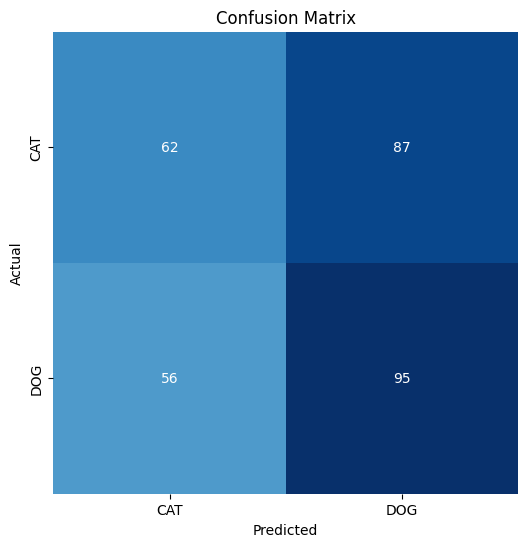

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.53      0.42      0.46       149
         DOG       0.52      0.63      0.57       151

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300



In [6]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
results2 = model2.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results2[0]))
print("Test Accuracy: {:.2f}%".format(results2[1] * 100))

predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


## my

In [23]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Veri setini yükleyip işleme fonksiyonları
def load_data():
    # "cat" ve "dog" klasörlerinden veriyi yükle
    cat_folder = "/content/Dog and Cat .png/Cat"
    dog_folder = "/content/Dog and Cat .png/Dog"

    cat_images = [cv2.imread(os.path.join(cat_folder, file), cv2.IMREAD_GRAYSCALE) for file in os.listdir(cat_folder)]
    dog_images = [cv2.imread(os.path.join(dog_folder, file), cv2.IMREAD_GRAYSCALE) for file in os.listdir(dog_folder)]

    # Etiketleri oluştur
    cat_labels = np.zeros(len(cat_images))
    dog_labels = np.ones(len(dog_images))

    # Veriyi birleştir
    X_data = np.array(cat_images + dog_images)
    y_data = np.concatenate([cat_labels, dog_labels])

    return X_data, y_data

# Veriyi yükle
X_data, y_data = load_data()
print("X_data",X_data.shape)
print("y_data",y_data.shape)




X_data (1000,)
y_data (1000,)


<ipython-input-23-d94f1af976f8>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.array(cat_images + dog_images)


In [ ]:
X_data[0]

In [ ]:

def preprocess_data(X_data, y_data):
    # Siyah beyaz yapma
    X_data_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_data])

    # Normalleştirme
    X_data_normalized = X_data_gray / 255.0

    return X_data_normalized, y_data

def prepare_for_1d_cnn(X_data_normalized, y_data):
    # 1D CNN modeline uygun hale getirme
    X_data_reshaped = X_data_normalized.reshape(X_data_normalized.shape[0], X_data_normalized.shape[1], 1)

    # Etiketleri kategorik hale getirme
    y_data_categorical = to_categorical(y_data)

    return X_data_reshaped, y_data_categorical

def create_1d_cnn_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_data_normalized.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model


In [ ]:
X_data_normalized, y_data = preprocess_data(X_data, y_data)


# Veriyi 1D CNN modeline uygun hale getir
X_data_reshaped, y_data_categorical = prepare_for_1d_cnn(X_data_normalized, y_data)

# Modeli oluştur ve eğit
model = create_1d_cnn_model()
model.fit(X_data_reshaped, y_data_categorical, epochs=60, batch_size=32, validation_split=0.2)